<a href="https://colab.research.google.com/github/rubyvanrooyen/observation_planning/blob/main/comet67P/67P_daily_pointing_calculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MeerKAT pointing calculations for comet 67P/Churyumov-Gerasimenko

## Library Installation

Use `skyfield` python package and published data files downloaded from the Minor Planet Center.    
https://rhodesmill.org/skyfield/kepler-orbits.html

In [ ]:
!pip install skyfield

     |████████████████████████████████| 378kB 5.3MB/s 
     |████████████████████████████████| 40kB 4.6MB/s 
     |████████████████████████████████| 266kB 35.4MB/s 
  Created wheel for skyfield: filename=skyfield-1.39-cp37-none-any.whl size=417583 sha256=4d9e0f9eafa306d33aa3aa7e67128b7c7cf1a959e141e98b4cc521e4703e631a
  Stored in directory: /root/.cache/pip/wheels/bb/a4/a6/2f7e3bc8ec08ffc7485c92d18dd726e0dbafc0f7a8b1519518
  Created wheel for jplephem: filename=jplephem-2.16-cp37-none-any.whl size=46796 sha256=ff40a3e1440cd531a59c4554906ffe27f9542f37064083792eeeee999dbf757a
  Stored in directory: /root/.cache/pip/wheels/6c/fe/9f/25afac10d5ef069cde1a252301efdf05401cb9a4ce42356788
Successfully built skyfield jplephem


Skyfield loads orbital elements from text files using the Pandas library.

In [ ]:
!pip install pandas

Library functions used in calculations

In [ ]:
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN
from skyfield.api import load, Topos
from skyfield.api import S, E, wgs84
from skyfield.data import mpc

from datetime import timedelta, datetime, timezone

from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS, AltAz
from astropy.coordinates import Longitude, Latitude, EarthLocation
from astropy.time import Time

import numpy as np

## Comet target definition
Use Skyfield to map comet ephemeris to sky coordinates given date of interest

In [ ]:
comet_name = '67P/Churyumov-Gerasimenko'
year = 2021
month = 7
day = 25

Build a dataframe of comets

In [ ]:
with load.open(mpc.COMET_URL) as f:
    comets = mpc.load_comets_dataframe(f)
# Keep only the most recent orbit for each comet,
# and index by designation for fast lookup.
comets = (comets.sort_values('reference')
          .groupby('designation', as_index=False).last()
          .set_index('designation', drop=False))

print(len(comets), 'comets loaded')
print(mpc.COMET_URL)

[#################################] 100% CometEls.txt


899 comets loaded
https://www.minorplanetcenter.net/iau/MPCORB/CometEls.txt


Read ephemeris of selected comet

In [ ]:
ts = load.timescale()
eph = load('de421.bsp')
sun, earth = eph['sun'], eph['earth']

ephem = comets.loc[comet_name]
print(ephem)
comet = sun + mpc.comet_orbit(ephem, ts, GM_SUN)
print(comet)

[#################################] 100% de421.bsp


designation                            67P/Churyumov-Gerasimenko
perihelion_year                                             2021
perihelion_month                                              11
perihelion_day                                            2.0542
perihelion_distance_au                                   1.21064
eccentricity                                            0.649796
argument_of_perihelion_degrees                           22.1261
longitude_of_ascending_node_degrees                      36.3341
inclination_degrees                                       3.8713
magnitude_g                                                   11
magnitude_k                                                    4
reference                                          MPEC 2021-N06
Name: 67P/Churyumov-Gerasimenko, dtype: object
Sum of 2 vectors:
 'de421.bsp' segment 0 SOLAR SYSTEM BARYCENTER -> 10 SUN
 _KeplerOrbit 10 SUN -> str


Relating the coordinates to ephem definition and katpoint:

* The position of a body is stored as the **Astrometric geocentric position**.
The epoch defaults to `J2000` and hence no precession gets applied.
These values are available as `a_ra` and `a_dec`.

* To calculate where the object will "appear" for an observer at the center of the Earth, apply corrections for light-travel time (for solar system objects), gravitational deflection of light, nutation and aberration to the astrometric position.
This position refers to the orientation of the Earth’s axes at the given date and time and hence are referred to as "epoch-of-date" coordinates;
this will not be same as star atlas position. This position is stored as **Apparent geocentric position** and are available as `g_ra` and `g_dec`.

* 
If an `Observer` (`Location`) is specified, parallax corrections are applied to `g_ra` and` g_dec`, to get the apparent position of the body as seen by the Observer on the surface of the Earth.
This position is called the **Apparent topocentric position** and are stored as `ra` and `dec`.
At the `Observer`‘s date and time, the `alt` and `az` properties defining the object's position in the sky is calculated.

In [ ]:
t = ts.utc(year, month, day)

# Astrometric geocentric position
astrometric = earth.at(t).observe(comet)
a_ra, a_dec, a_distance = astrometric.radec()
print(f'Astrometric ({a_ra.hours}, {a_dec.degrees}) @ distance {a_distance.au} [AU]')

# Apparent geocentric position
apparent = astrometric.apparent()
g_ra, g_dec, g_distance = astrometric.apparent().radec()
print(f'Apparent ({g_ra.hours}, {g_dec.degrees}) @ distance {g_distance.au} [AU]')

# Apparent topocentric position
meerkat = earth + Topos('30.7130 S', '21.4430 E')
# meerkat = earth + wgs84.latlon(30.7130 * S, 21.4430 * E)
apparent = meerkat.at(t).observe(comet).apparent()
ra, dec, distance = apparent.radec()
print(f'Topocentric    ({ra.hours}, {dec.degrees}) @ distance {distance.au} [AU]')
ra, dec, distance = apparent.radec('date')
print(f'Topocentric    ({ra.hours}, {dec.degrees}) @ distance {distance.au} [AU]')
print(f'Topocentric    ({ra}, {dec}) @ distance {distance.au} [AU]')

alt, az, distance = apparent.altaz()
print(f'Horizontal  ({alt.degrees}, {az.degrees}) @ distance {distance.au} [AU]')


Astrometric (1.3405746072139022, 3.6709829908869906) @ distance 1.1681507571000782 [AU]
Apparent (1.3406380670965705, 3.6718253477308873) @ distance 1.1681507571000782 [AU]
Topocentric    (1.3407405475342773, 3.6729480437322075) @ distance 1.168131725488502 [AU]
Topocentric    (1.3590883456849534, 3.784383379635797) @ distance 1.1681317254885029 [AU]
Topocentric    (01h 21m 32.72s, +03deg 47' 03.8") @ distance 1.1681317254885029 [AU]
Horizontal  (26.470540271030934, 67.56911718392816) @ distance 1.1681317254885029 [AU]


In [ ]:
print(f'Comet {comet.target}')
print(f'  Observation date {t.utc_strftime()}')
print(f'  Astrometric ({a_ra}, {a_dec}) @ distance {a_distance.au} [AU]')
print(f'  Apparent ({g_ra}, {g_dec}) @ distance {g_distance.au} [AU]')
print(f'  Topocentric    ({ra}, {dec}) @ distance {distance.au} [AU]')
print(f'  Horizontal  ({alt}, {az}) @ distance {distance.km/1e6} [M Km]')

Comet 67P/Churyumov-Gerasimenko
  Observation date 2021-07-25 00:00:00 UTC
  Astrometric (01h 20m 26.07s, +03deg 40' 15.5") @ distance 1.1681507571000782 [AU]
  Apparent (01h 20m 26.30s, +03deg 40' 18.6") @ distance 1.1681507571000782 [AU]
  Topocentric    (01h 21m 32.72s, +03deg 47' 03.8") @ distance 1.1681317254885029 [AU]
  Horizontal  (26deg 28' 13.9", 67deg 34' 08.8") @ distance 174.75001883019692 [M Km]


Compare values against online view finder    
https://theskylive.com/planetarium?objects=sun-moon-67p-c2020f3-mercury-venus-mars-jupiter-saturn-uranus-neptune-pluto&localdata=-30.96827%7C22.13303%7CCarnarvon+(ZA)%7CAfrica%2FJohannesburg%7C0&obj=67p&h=00&m=00&date=2021-07-07#ra|0.6986111111184528|dec|-0.1522222222222532|fov|50

## Transit
Find transit time and equatorial observation coordinates

In [ ]:
UTC = timezone(timedelta(hours=0))
obs_date = datetime(year, month, day, 0, 0, 0, tzinfo=UTC)

# nr seconds in day sampled at some decimation interval
decimate = 30  # sec
time_samples = range(0, 24*3600, decimate)  # sec

Alts = []
Datetimes = []
for time_cnt in time_samples:
    t = ts.from_datetime(obs_date + timedelta(seconds=time_cnt))
    alt, az, distance = meerkat.at(t).observe(comet).apparent().altaz()

    Alts.append(alt.degrees)
    Datetimes.append(t.utc_datetime())

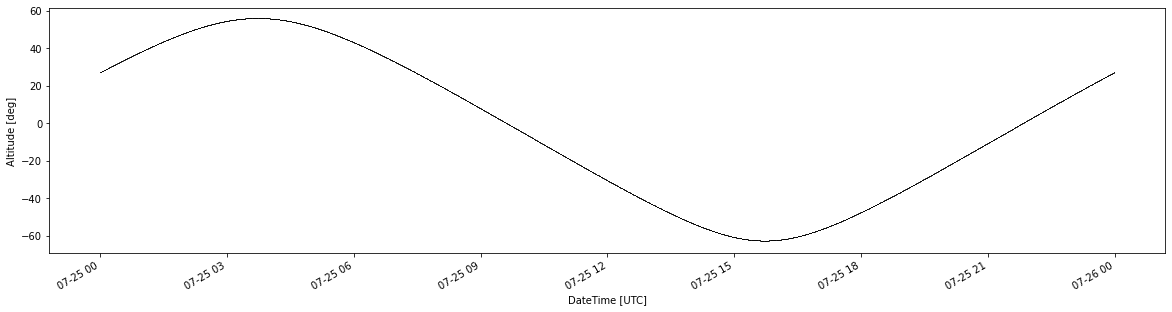

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
dates = matplotlib.dates.date2num(Datetimes)

plt.figure
fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(20, 5),  # W x H
                       facecolor='white')
ax.plot_date(dates, Alts, 'k,', alpha=0.7)
ax.set_ylabel('Altitude [deg]')
ax.set_xlabel('DateTime [UTC]')

# beautify the x-labels
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# transit
transit_idx = np.argmax(Alts)
# rise and set time
if Alts[0] > 0:
    set_idx = np.nonzero(np.array(Alts)<=0)[0][0]
    rise_idx = set_idx + np.nonzero(np.array(Alts)[set_idx:]>=0)[0][0]
else:
    rise_idx = np.nonzero(np.array(Alts)>=0)[0][0]
    set_idx = rise_idx + np.nonzero(np.array(Alts)[rise_idx:]<=0)[0][0]

In [ ]:
rise_time = Datetimes[rise_idx]
transit_time = Datetimes[transit_idx]
set_time = Datetimes[set_idx]
print(f'Time table for {t.utc_strftime()}')
print(f'   Rising: {rise_time}')
print(f'  Transit: {transit_time} @ {Alts[transit_idx]:.3f} [deg]')
print(f'  Setting: {set_time}')

Time table for 2021-07-25 23:59:30 UTC
   Rising: 2021-07-25 21:52:30+00:00
  Transit: 2021-07-25 03:43:30+00:00 @ 55.468 [deg]
  Setting: 2021-07-25 09:34:30+00:00


# Skyfield observational coordinates

In [ ]:
t = ts.utc(year, month, day)
date = t.utc_strftime(format='%Y-%m-%d')

comet_coords = {}
comet_coords[comet.target] = {'date': date}
print(comet_coords)

# geocentric astrometric coords (a_ra, a_dec, dt)
comet_coords[comet.target]['astrometric'] = {'rise': None, 'transit': None, 'set': None}
# topocentric apparent coords (alt, az, dist)
comet_coords[comet.target]['skyfield'] = {'rise': None, 'transit': None, 'set': None, 'radius': None}

{'67P/Churyumov-Gerasimenko': {'date': '2021-07-25'}}


In [ ]:
def comet_location(datetime_obj):
    t = ts.from_datetime(datetime_obj)
    astrometric = earth.at(t).observe(comet)
    a_ra, a_dec, _ = astrometric.radec()
    apparent = meerkat.at(t).observe(comet).apparent()
    alt, az, distance = apparent.altaz()
    return t, a_ra, a_dec, alt, az, distance

In [ ]:
# rise
t, ra, dec, alt, az, distance = comet_location(rise_time)
dt = t.utc_strftime(format="%Y-%m-%d %H:%M:%S")
comet_coords[comet.target]['astrometric']['rise'] = (ra, dec, dt)
comet_coords[comet.target]['skyfield']['rise'] = (alt.degrees, az.degrees, distance)
# transit
t, ra, dec, alt, az, distance = comet_location(transit_time)
dt = t.utc_strftime(format="%Y-%m-%d %H:%M:%S")
comet_coords[comet.target]['astrometric']['transit'] = (ra, dec, dt)
comet_coords[comet.target]['skyfield']['transit'] = (alt.degrees, az.degrees, distance)
# set
t, ra, dec, alt, az, distance = comet_location(set_time)
dt = t.utc_strftime(format="%Y-%m-%d %H:%M:%S")
comet_coords[comet.target]['astrometric']['set'] = (ra, dec, dt)
comet_coords[comet.target]['skyfield']['set'] = (alt.degrees, az.degrees, distance)

# angular distance travelled
t = ts.from_datetime(rise_time)
comet_rising = meerkat.at(t).observe(comet)
t = ts.from_datetime(set_time)
comet_setting = meerkat.at(t).observe(comet)
rho = comet_rising.separation_from(comet_setting)
comet_coords[comet.target]['skyfield']['radius'] = rho.degrees

# Ephem observational coordinates

In [ ]:
import ephem

# Observer
MKT = ephem.Observer()
MKT.lat = '-30:42:39.8'
MKT.lon = '21:26:38.0'
MKT.elevation = 1086.6
MKT.horizon = ephem.degrees('15.0')
MKT.epoch = ephem.J2000

In [ ]:
comet_coords[comet.target]['ephem'] = {'rise': None, 'transit': None, 'set': None, 'radius': None}

comet_ = ephem.FixedBody()
comet_.name = '67P'
# rise
comet_rising = ephem.FixedBody()
comet_rising.name = '67P'
ra, dec, dt = comet_coords[comet.target]['astrometric']['rise']
ra_hms = ra.hms()
ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
comet_rising._ra = ephem.hours(ra_str)
dec_dms = dec.signed_dms()
dec_str = f'{dec_dms[0]*int(dec_dms[1])}:{int(dec_dms[2])}:{dec_dms[3]:.3f}'
comet_rising._dec = ephem.degrees(dec_str)
MKT.date = ephem.Date(dt)
comet_rising.compute(MKT)
comet_coords[comet.target]['ephem']['rise'] = (np.degrees(comet_rising.alt),
                                               np.degrees(comet_rising.az),
                                               None)
# transit
ra, dec, dt = comet_coords[comet.target]['astrometric']['transit']
ra_hms = ra.hms()
ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
comet_._ra = ephem.hours(ra_str)
dec_dms = dec.signed_dms()
dec_str = f'{dec_dms[0]*int(dec_dms[1])}:{int(dec_dms[2])}:{dec_dms[3]:.3f}'
comet_._dec = ephem.degrees(dec_str)
MKT.date = ephem.Date(dt)
comet_.compute(MKT)
comet_coords[comet.target]['ephem']['transit'] = (np.degrees(comet_.alt),
                                                  np.degrees(comet_.az),
                                                  None)

# set
comet_setting = ephem.FixedBody()
comet_setting.name = '67P'
ra, dec, dt = comet_coords[comet.target]['astrometric']['set']
ra_hms = ra.hms()
ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
comet_setting._ra = ephem.hours(ra_str)
dec_dms = dec.signed_dms()
dec_str = f'{dec_dms[0]*int(dec_dms[1])}:{int(dec_dms[2])}:{dec_dms[3]:.3f}'
comet_setting._dec = ephem.degrees(dec_str)
MKT.date = ephem.Date(dt)
comet_setting.compute(MKT)
comet_coords[comet.target]['ephem']['set'] = (np.degrees(comet_setting.alt),
                                              np.degrees(comet_setting.az),
                                              None)

# angular distance travelled
rho = np.degrees(ephem.separation(comet_rising, comet_setting))
comet_coords[comet.target]['ephem']['radius'] = rho

# Astropy observational coordinates

In [ ]:
location = EarthLocation.from_geodetic(Longitude('21:26:38.0',
                                                 u.degree,
                                                 wrap_angle=180. * u.degree,
                                                 copy=False),
                                       Latitude('-30:42:39.8',
                                                u.degree,
                                                copy=False),
                                       height=u.Quantity(1086.6,
                                                         u.m,
                                                         copy=False))

In [ ]:
comet_coords[comet.target]['astropy'] = {'rise': None, 'transit': None, 'set': None, 'radius': None}

# rise
ra, dec, dt = comet_coords[comet.target]['astrometric']['rise']
comet_rising = SkyCoord(ra=ra.hours*u.hour, dec=dec.degrees*u.deg, frame='icrs')
obs_time = Time(dt)
observer = AltAz(location=location, obstime=obs_time)
altaz = comet_rising.transform_to(observer)
comet_coords[comet.target]['astropy']['rise'] = (altaz.alt.deg, altaz.az.deg, None)

# transit
ra, dec, dt = comet_coords[comet.target]['astrometric']['transit']
comet_ = SkyCoord(ra=ra.hours*u.hour, dec=dec.degrees*u.deg, frame='icrs')
obs_time = Time(dt)
observer = AltAz(location=location, obstime=obs_time)
altaz = comet_.transform_to(observer)
comet_coords[comet.target]['astropy']['transit'] = (altaz.alt.deg, altaz.az.deg, None)

# set
ra, dec, dt = comet_coords[comet.target]['astrometric']['set']
comet_setting = SkyCoord(ra=ra.hours*u.hour, dec=dec.degrees*u.deg, frame='icrs')
obs_time = Time(dt)
observer = AltAz(location=location, obstime=obs_time)
altaz = comet_setting.transform_to(observer)
comet_coords[comet.target]['astropy']['set'] = (altaz.alt.deg, altaz.az.deg, None)

# angular distance travelled
rho = comet_rising.separation(comet_setting).to(u.deg)
comet_coords[comet.target]['astropy']['radius'] = rho.degree

# Output

# Comparison
Compare (alt, az) coord calc for `skyfield`, `ephem` and `astropy`

In [ ]:
for comet_ in comet_coords:
    print(comet_)
    print(comet_coords[comet_]['date'])
    for key0 in ['rise', 'transit', 'set']:
        print(f"{key0.capitalize()} time: {comet_coords[comet_]['astrometric'][key0][2]} UTC")
        ra = comet_coords[comet_]['astrometric'][key0][0]
        dec = comet_coords[comet_]['astrometric'][key0][1]
        print(f'  Equatorial ({ra}, {dec})')
        for key1 in ['skyfield', 'ephem', 'astropy']:
            alt = comet_coords[comet_][key1][key0][0]
            az = comet_coords[comet_][key1][key0][1]
            dist = comet_coords[comet_][key1][key0][2]
            if dist is not None:
                print(f'  Horizontal ({alt:.3f}, {az:.3f}) @ distance {dist.km/1e6:.3f} [mKm]')
            else:
                print(f'  Horizontal ({alt:.3f}, {az:.3f})')
    for key1 in ['skyfield', 'ephem', 'astropy']:
        rho = comet_coords[comet.target][key1]['radius']
        print(f'Angular distance travelled during period visible {rho:.3f} [deg]')

67P/Churyumov-Gerasimenko
2021-07-25
Rise time: 2021-07-25 21:52:30 UTC
  Equatorial (01h 22m 30.55s, +03deg 52' 27.5")
  Horizontal (0.094, 85.305) @ distance 172.803 [mKm]
  Horizontal (0.555, 85.304)
  Horizontal (0.097, 85.304)
Transit time: 2021-07-25 03:43:30 UTC
  Equatorial (01h 20m 47.21s, +03deg 42' 19.9")
  Horizontal (55.468, 0.141) @ distance 174.415 [mKm]
  Horizontal (55.482, 0.138)
  Horizontal (55.471, 0.139)
Set time: 2021-07-25 09:34:30 UTC
  Equatorial (01h 21m 20.45s, +03deg 45' 35.4")
  Horizontal (-0.067, 274.466) @ distance 173.898 [mKm]
  Horizontal (0.414, 274.465)
  Horizontal (-0.066, 274.465)
Angular distance travelled during period visible 0.316 [deg]
Angular distance travelled during period visible 0.313 [deg]
Angular distance travelled during period visible 0.313 [deg]


# Observation coords
Summary for scheduling and documentation

In [ ]:
for comet_ in comet_coords:
    for key0 in ['rise', 'transit', 'set']:
        print(f"{key0.capitalize()}")
        ra, dec, dt = comet_coords[comet_]['astrometric'][key0]
        ra_hms = ra.hms()
        ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
        dec_dms = dec.signed_dms()
        dec_str = f'{int(dec_dms[0])*int(dec_dms[1])}:{int(dec_dms[2])}:{dec_dms[3]:.3f}'
        alt, az, dist = comet_coords[comet_]['skyfield'][key0]
        rho = comet_coords[comet.target]['skyfield']['radius']
        print(f"  Time:  {dt} UTC")
        print(f'  RaDec: {ra_str}, {dec_str}')
        print(f'  Alt:   {alt:.5f}')
        print(f'  Dist:  {rho:.3f} [deg], {dist.au:.4f} [AU]')

Rise
  Time:  2021-07-25 21:52:30 UTC
  RaDec: 1:22:30.554, 3:52:27.460
  Alt:   0.09403
  Dist:  0.316 [deg], 1.1551 [AU]
Transit
  Time:  2021-07-25 03:43:30 UTC
  RaDec: 1:20:47.208, 3:42:19.909
  Alt:   55.46798
  Dist:  0.316 [deg], 1.1659 [AU]
Set
  Time:  2021-07-25 09:34:30 UTC
  RaDec: 1:21:20.454, 3:45:35.448
  Alt:   -0.06741
  Dist:  0.316 [deg], 1.1624 [AU]


In [ ]:
def elev_calc(datetime_obj, risetime=False, settime=False):
    UTC = timezone(timedelta(hours=0))
    obs_date = datetime(datetime_obj.year, datetime_obj.month, datetime_obj.day, 0, 0, 0, tzinfo=UTC)
    # nr seconds in day sampled at some decimation interval
    decimate = 30  # sec
    time_samples = range(0, 24*3600, decimate)  # sec
    
    Alts = []
    Datetimes = []
    for time_cnt in time_samples:
        t = ts.from_datetime(obs_date + timedelta(seconds=time_cnt))
        alt, az, distance = meerkat.at(t).observe(comet).apparent().altaz()

        Alts.append(alt.degrees)
        Datetimes.append(t.utc_datetime())

    # transit
    transit_idx = np.argmax(Alts)    
    # rise and set time
    if Alts[0] > 0:
        set_idx = np.nonzero(np.array(Alts)<=0)[0][0]
        rise_idx = set_idx + np.nonzero(np.array(Alts)[set_idx:]>=0)[0][0]
    else:
        rise_idx = np.nonzero(np.array(Alts)>=0)[0][0]
        set_idx = rise_idx + np.nonzero(np.array(Alts)[rise_idx:]<=0)[0][0]
    
    if risetime:
        return Datetimes[rise_idx]
    elif settime:
        return Datetimes[set_idx]
    else:  # transit
        return Datetimes[transit_idx]

ra, dec, rise_time = comet_coords[comet.target]['astrometric']['rise']
ra, dec, set_time = comet_coords[comet.target]['astrometric']['set']
date_time_rise = datetime.strptime(rise_time, '%Y-%m-%d %H:%M:%S')
date_time_set = datetime.strptime(set_time, '%Y-%m-%d %H:%M:%S')
time_delta = date_time_set-date_time_rise
if time_delta.total_seconds() < 0:
    yesterday = date_time_rise - timedelta(days=1)
    rise_time = elev_calc(yesterday, risetime=True).strftime(format="%Y-%m-%d %H:%M:%S")

date_time_rise = datetime.strptime(rise_time, '%Y-%m-%d %H:%M:%S')
time_delta = date_time_set-date_time_rise

In [ ]:
ra, dec, dt = comet_coords[comet_]['astrometric']['transit']
ra_hms = ra.hms()
ra_str = f'{int(ra_hms[0])}:{int(ra_hms[1])}:{ra_hms[2]:.3f}'
dec_dms = dec.signed_dms()
dec_str = f'{int(dec_dms[0])*int(dec_dms[1])}:{int(dec_dms[2])}:{dec_dms[3]:.3f}'

alt, az, dist = comet_coords[comet_]['skyfield']['transit']

UTC = timezone(timedelta(hours=0))
# angular distance travelled
t = ts.from_datetime(datetime(date_time_rise.year, date_time_rise.month, date_time_rise.day, 0, 0, 0, tzinfo=UTC))
comet_rising = meerkat.at(t).observe(comet)
t = ts.from_datetime(datetime(date_time_set.year, date_time_set.month, date_time_set.day, 0, 0, 0, tzinfo=UTC))
comet_setting = meerkat.at(t).observe(comet)
rho = comet_rising.separation_from(comet_setting)

print(f"Date \t   Time \t RA \t         Dec \t         d (deg) \t D [AU]")
print(f"{dt} \t {ra_str} \t {dec_str} \t {rho.degrees:.4f} \t {dist.au:.4f}")
print(f"Comet is visible for {time_delta.total_seconds()/3600.:.3f} hrs and deviates {rho.degrees:.4f} degrees ({rho.arcminutes():.3f} arcmin) from assigned pointing position during this time")


Date 	   Time 	 RA 	         Dec 	         d (deg) 	 D [AU]
2021-07-25 03:43:30 	 1:20:47.208 	 3:42:19.909 	 0.6061 	 1.1659
Comet is visible for 11.683 hrs and deviates 0.6061 degrees (36.366 arcmin) from assigned pointing position during this time
